In [25]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="/home/zach/intelligent_machines/data",
    train=True,
    download=False,
    transform=transforms.ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="/home/zach/intelligent_machines/data",
    train=False,
    download=False,
    transform=transforms.ToTensor(),
)

print(training_data.data.shape)
print(test_data.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


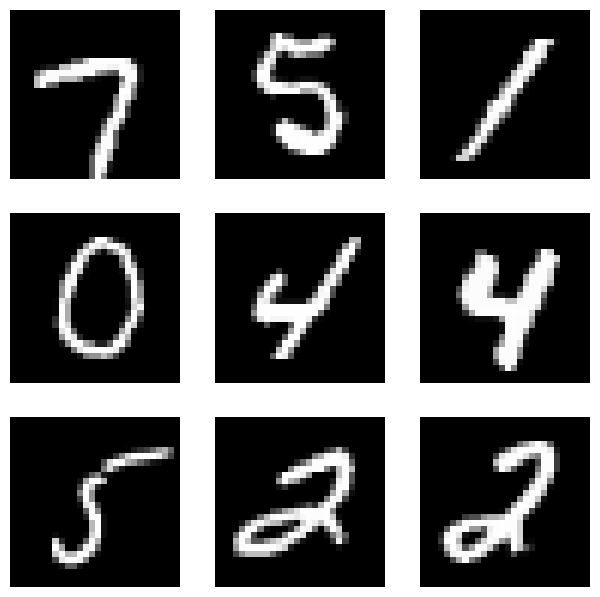

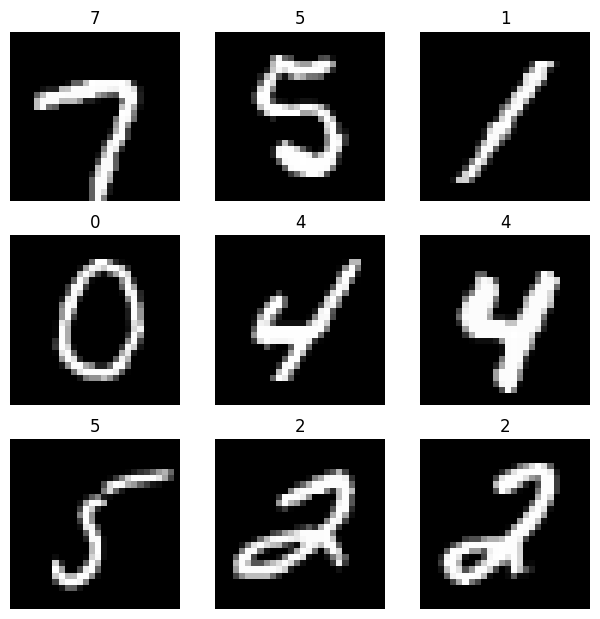

In [3]:
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
cols, rows = 3, 3

# Store images and labels
img_display = []

for i in range(cols * rows):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    img_display.append((img, label))



figure = plt.figure(figsize=(cols*2.5, rows*2.5))

for i in range(cols * rows):
    img, label = img_display[i]
    figure.add_subplot(rows, cols, i+1)
    # plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")


figure = plt.figure(figsize=(cols*2.5, rows*2.5))

for i in range(cols * rows):
    img, label = img_display[i]
    figure.add_subplot(rows, cols, i+1)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")


Using cuda device


In [6]:

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(14 * 14 * 3, 10),
        )

    def forward(self, x):
        logits = self.conv_stack(x)
        return logits

model = NeuralNetwork().to(device)
# print(model)
summary(model, input_size=(batch_size, 1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [64, 10]                  --
├─Sequential: 1-1                        [64, 10]                  --
│    └─Conv2d: 2-1                       [64, 3, 28, 28]           30
│    └─ReLU: 2-2                         [64, 3, 28, 28]           --
│    └─MaxPool2d: 2-3                    [64, 3, 14, 14]           --
│    └─Flatten: 2-4                      [64, 588]                 --
│    └─Linear: 2-5                       [64, 10]                  5,890
Total params: 5,920
Trainable params: 5,920
Non-trainable params: 0
Total mult-adds (M): 1.88
Input size (MB): 0.20
Forward/backward pass size (MB): 1.21
Params size (MB): 0.02
Estimated Total Size (MB): 1.43

In [59]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [60]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [61]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [62]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303442  [   64/60000]
loss: 2.300862  [ 6464/60000]
loss: 2.300169  [12864/60000]
loss: 2.293301  [19264/60000]
loss: 2.288692  [25664/60000]
loss: 2.290117  [32064/60000]
loss: 2.288955  [38464/60000]
loss: 2.279499  [44864/60000]
loss: 2.274159  [51264/60000]
loss: 2.264509  [57664/60000]
Test Error: 
 Accuracy: 37.0%, Avg loss: 2.258028 

Epoch 2
-------------------------------
loss: 2.257524  [   64/60000]
loss: 2.246404  [ 6464/60000]
loss: 2.225631  [12864/60000]
loss: 2.185876  [19264/60000]
loss: 2.170447  [25664/60000]
loss: 2.163673  [32064/60000]
loss: 2.092680  [38464/60000]
loss: 2.084276  [44864/60000]
loss: 1.980191  [51264/60000]
loss: 1.875841  [57664/60000]
Test Error: 
 Accuracy: 68.4%, Avg loss: 1.860284 

Epoch 3
-------------------------------
loss: 1.875806  [   64/60000]
loss: 1.748472  [ 6464/60000]
loss: 1.645489  [12864/60000]
loss: 1.473218  [19264/60000]
loss: 1.379163  [25664/60000]
loss: 1.332588  [32064/600

In [46]:
print(model)

NeuralNetwork(
  (conv_stack): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=588, out_features=10, bias=True)
  )
)


In [63]:
print(dict(model.named_modules()))

{'': NeuralNetwork(
  (conv_stack): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=588, out_features=10, bias=True)
  )
), 'conv_stack': Sequential(
  (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=588, out_features=10, bias=True)
), 'conv_stack.0': Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 'conv_stack.1': ReLU(), 'conv_stack.2': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), 'conv_stack.3': Flatten(start_dim=1, end_dim=-1), 'conv_stack.4': Linear(in_features=588, out_features=10, bias=True)}


In [8]:

activation = {}

def hook_fn(module, input, output):
    activation[module] = output.detach()

In [9]:
model.conv_stack[1].register_forward_hook(hook_fn)

torch.Size([1, 1, 28, 28])
Predicted: "6", Actual: "2"
torch.Size([1, 3, 28, 28])


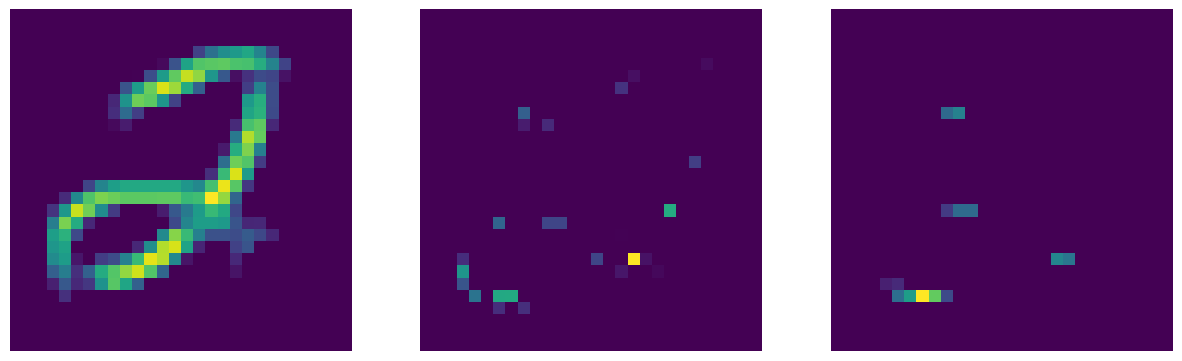

In [24]:
model.eval()
idx = torch.randint(0, len(test_data), (1,)).item()
x, y = test_data[idx][0], test_data[idx][1]
x = x.unsqueeze(0)
print(x.shape)
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = labels_map[pred[0].argmax(0).item()], labels_map[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')# print(activation["ReLU()"])

for key, item in activation.items():
    print(item.shape)
    act = item.squeeze(0) 
    print(act)

    num_filters = min(8, act.shape[0])  # Display up to 8 filters
    fig, axes = plt.subplots(1, num_filters, figsize=(15, 5))

    for i in range(num_filters):
        ax = axes[i]
        ax.imshow(act[i].cpu().numpy(), cmap='viridis')
        ax.axis("off")

    plt.show()


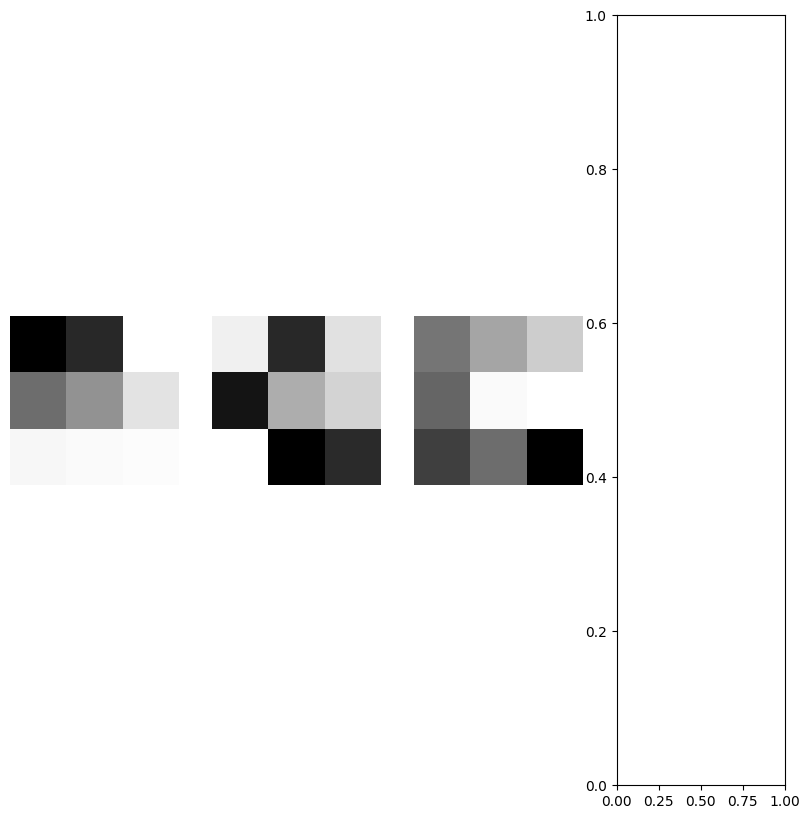

In [26]:
# Extract the first convolutional layer's weights
layer = model.conv_stack[0]
kernels = layer.weight.detach().cpu().numpy()  # Convert to NumPy

# Normalize the kernel values for better visualization
kernels = (kernels - kernels.min()) / (kernels.max() - kernels.min())

# Determine the number of filters
num_kernels = kernels.shape[0]  # Number of filters

# Set up a grid for visualization
rows = int(np.sqrt(num_kernels))
cols = (num_kernels // rows) + 1

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < num_kernels:
        kernel = kernels[i]  # Select the i-th filter
        kernel = np.transpose(kernel, (1, 2, 0))  # Change shape to (H, W, C)

        # If the filter is grayscale (1 channel), remove extra dim
        if kernel.shape[-1] == 1:
            kernel = kernel[:, :, 0]

        ax.imshow(kernel, cmap='gray' if kernel.ndim == 2 else None)
        ax.axis('off')

plt.show()